In [13]:
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
from models.convolutional_vae_v2_60x30 import ConvolutionalVAEV2, preprocess_grid, postprocess_grid
from models.pipeline import Pipeline
from utils.view import draw_grid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = ConvolutionalVAEV2(
    in_channels=10, 
    starting_filters=64, 
    latent_dim=256,
    feature_dim=[4, 8]
).to(device)

checkpoint = torch.load('../../checkpoints/conv_vaev2_256_60x30_rev.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_grid,
    postprocess_fn=postprocess_grid,
)
model_type = "vae"

In [39]:
def infer_arc_transformation(pipeline, demo_pairs, test_input, test_output, train_weight=0.7):
    demo_latents = []
    for inp, out in demo_pairs:
        concat_demo = torch.cat([inp, out], dim=2).unsqueeze(0)  # 30x60
        z_demo, _ = pipeline.encode(concat_demo) 
        demo_latents.append(z_demo)
    
    avg_demo_latent = torch.mean(torch.stack(demo_latents), dim=0)
    
    test_template = torch.cat([test_input, torch.zeros_like(test_input)], dim=2).unsqueeze(0)
    
    z_test_template, _ = pipeline.encode(test_template)

    z_interpolated = (1 - train_weight) * z_test_template + train_weight * avg_demo_latent
    
    full_result = pipeline.decode(z_interpolated).squeeze(0)

    predicted_output = full_result[:, :, 30:]
    predicted_output = pipeline.decompress_and_postprocess(predicted_output, test_output)
    return predicted_output

In [10]:
from utils.load_data import get_grids

data, _  = get_grids(filepath="../../data/evaluation", split=False)

In [36]:
def process_train_pairs(pipeline: Pipeline, train_pairs):
    z_pairs = []
    for input, output in train_pairs:
        input = pipeline.preprocess_and_compress(input)
        output = pipeline.preprocess_and_compress(output)
        z_pairs.append((input, output))
    
    return z_pairs

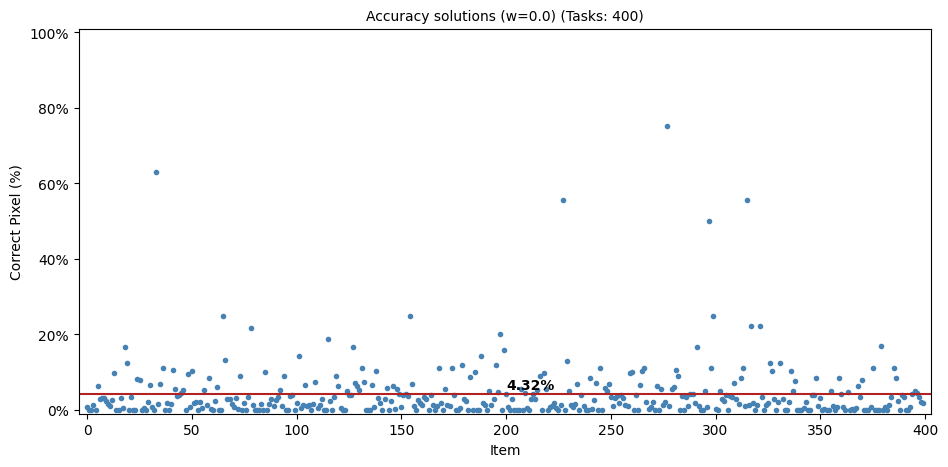

Number of 100% Correct: 0
Number of 90%+ Correct: 0
Number of 80%+ Correct: 0
Number of 70%+ Correct: 1


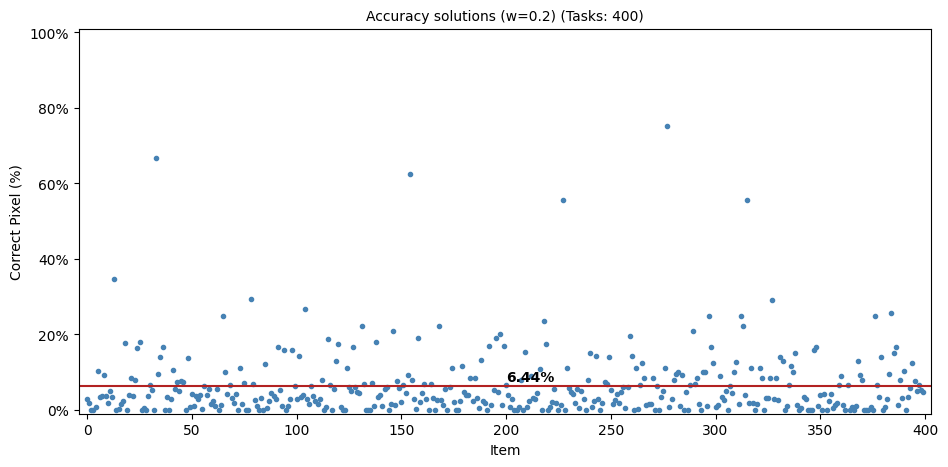

Number of 100% Correct: 0
Number of 90%+ Correct: 0
Number of 80%+ Correct: 0
Number of 70%+ Correct: 1


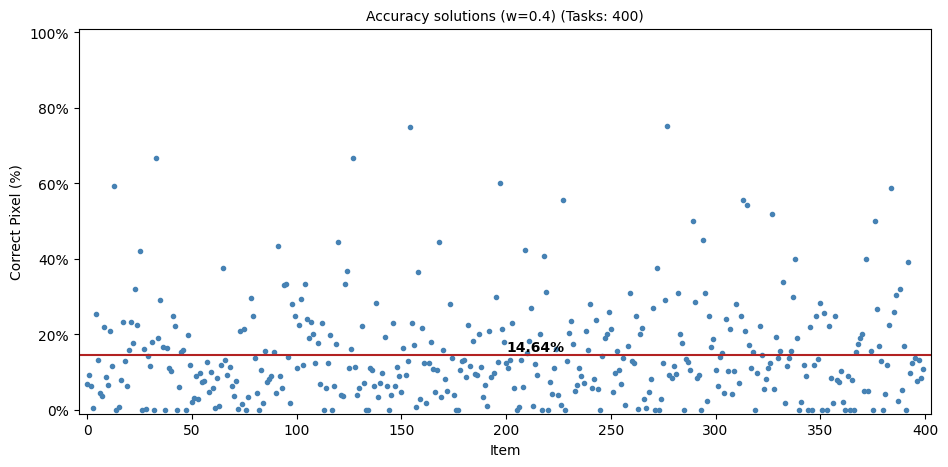

Number of 100% Correct: 0
Number of 90%+ Correct: 0
Number of 80%+ Correct: 0
Number of 70%+ Correct: 2


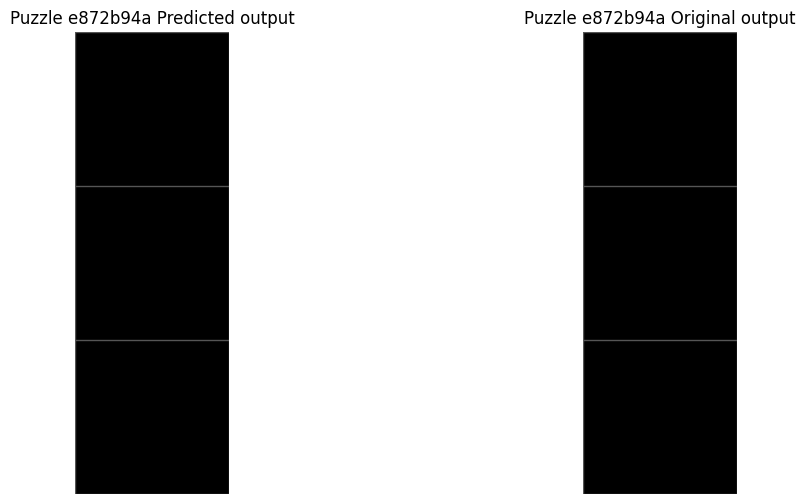

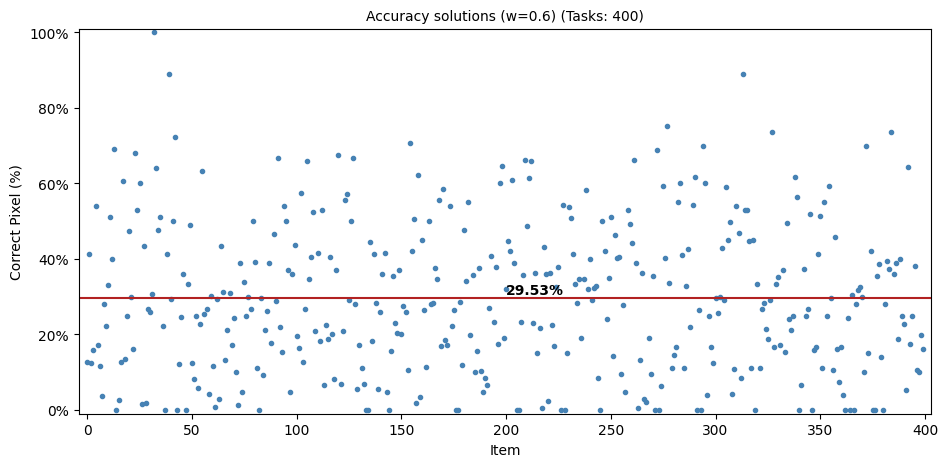

Number of 100% Correct: 1
Number of 90%+ Correct: 1
Number of 80%+ Correct: 3
Number of 70%+ Correct: 10


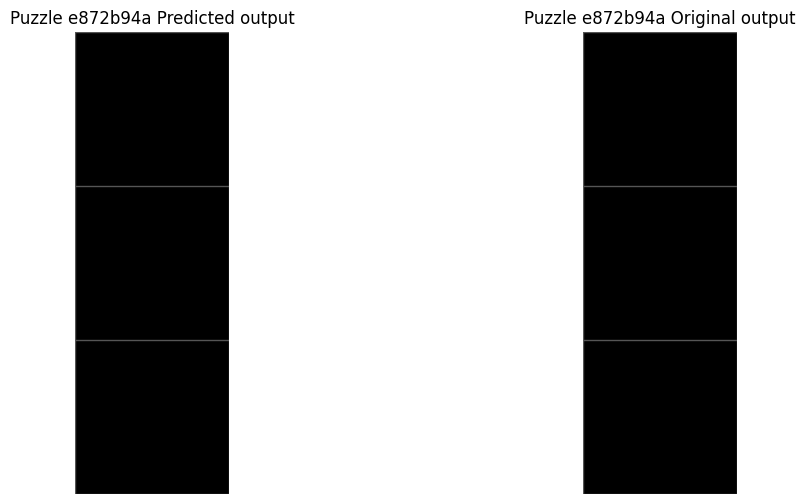

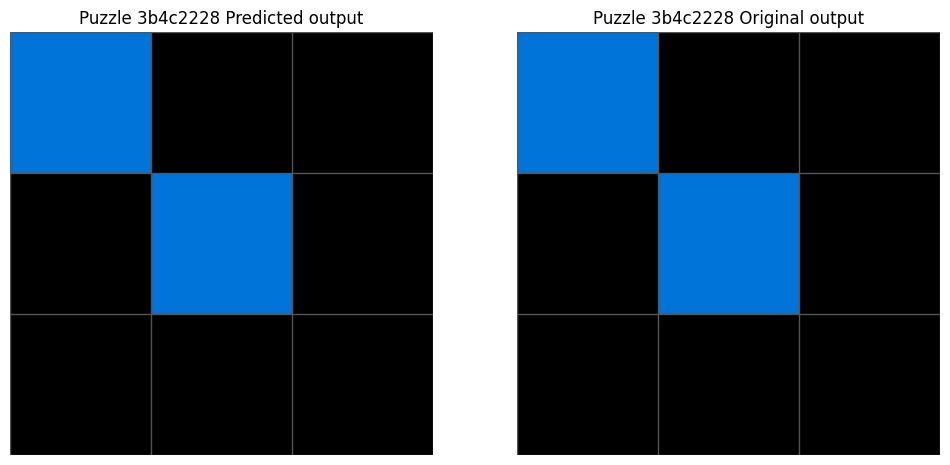

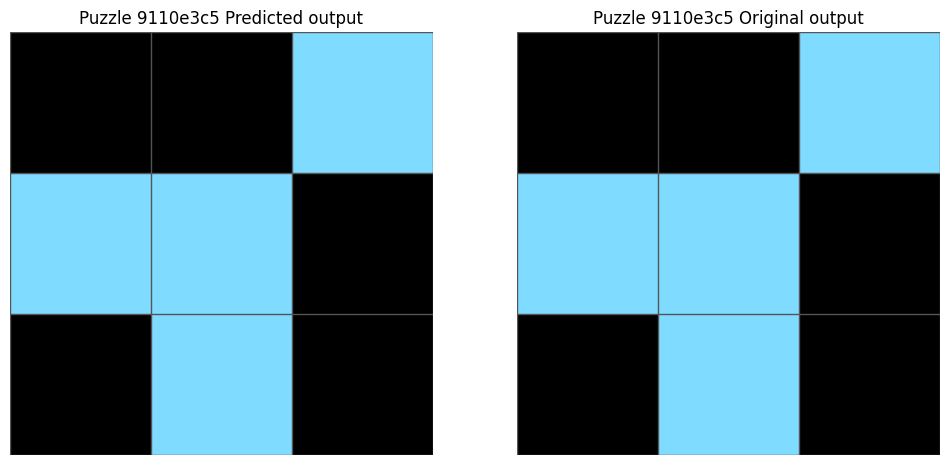

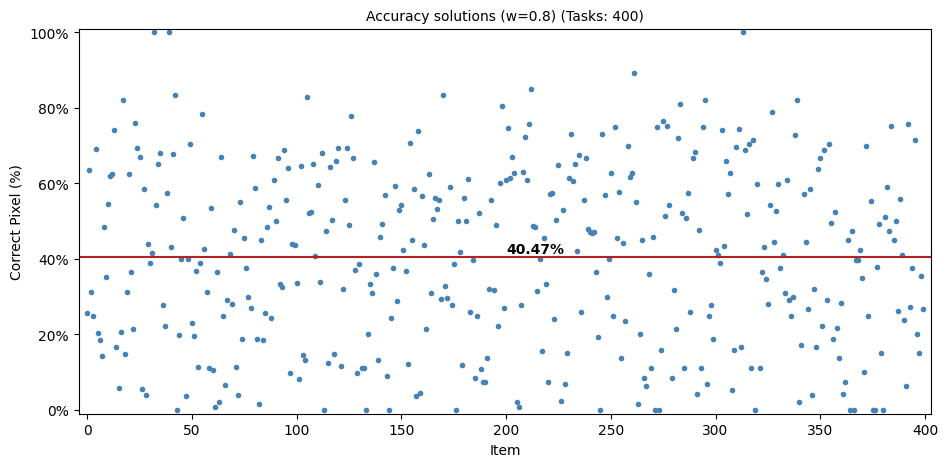

Number of 100% Correct: 3
Number of 90%+ Correct: 3
Number of 80%+ Correct: 13
Number of 70%+ Correct: 43


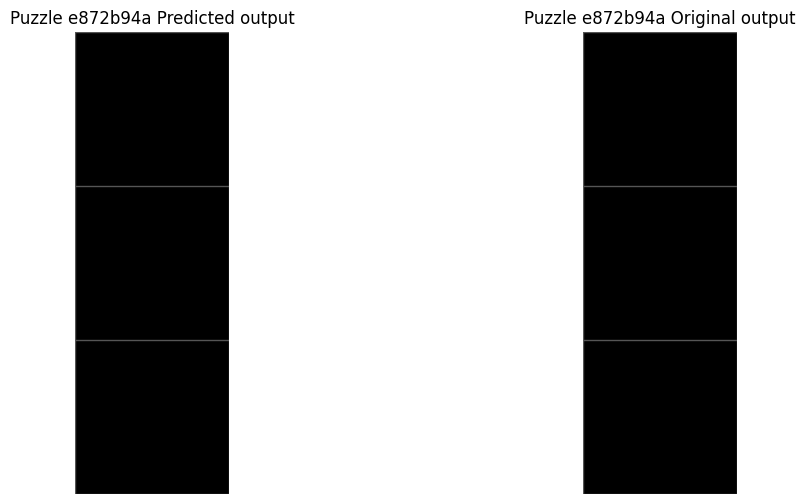

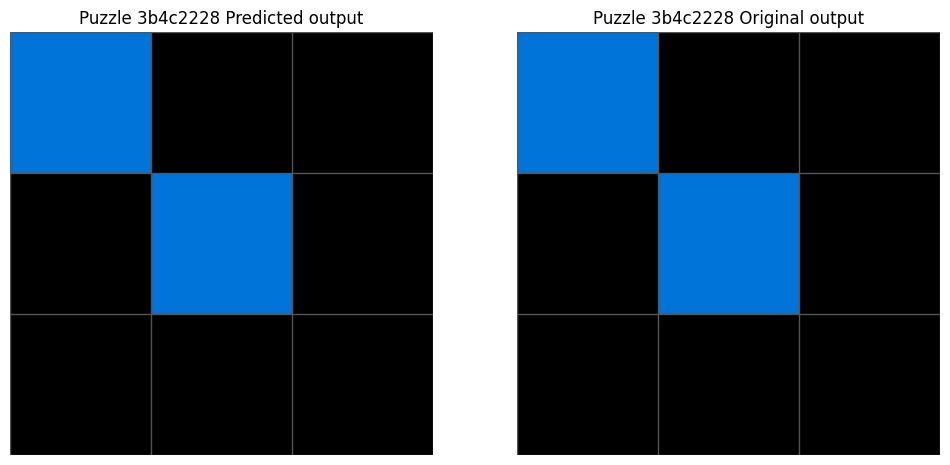

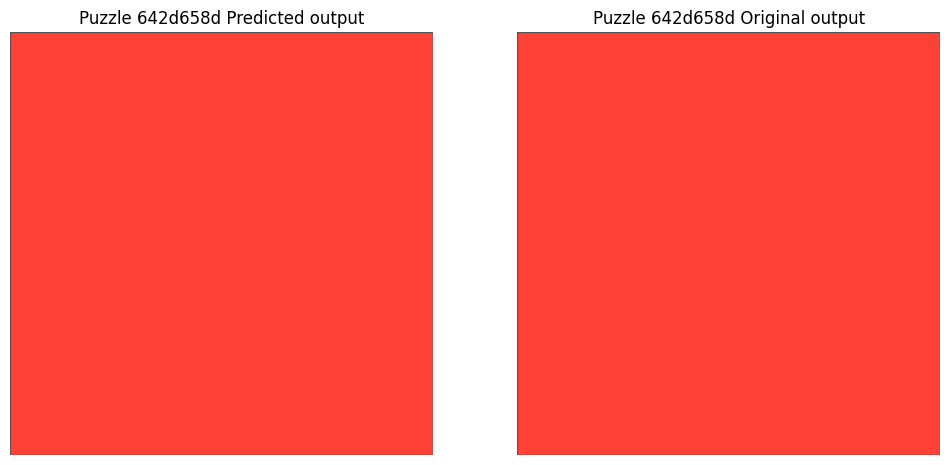

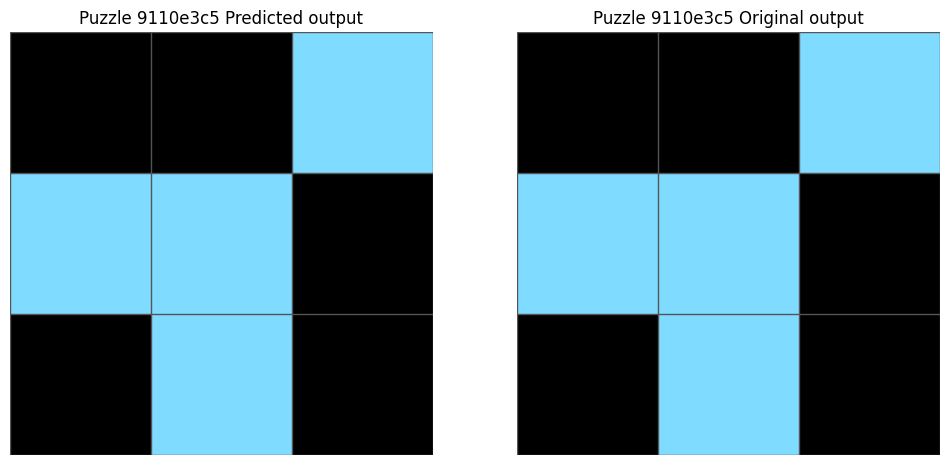

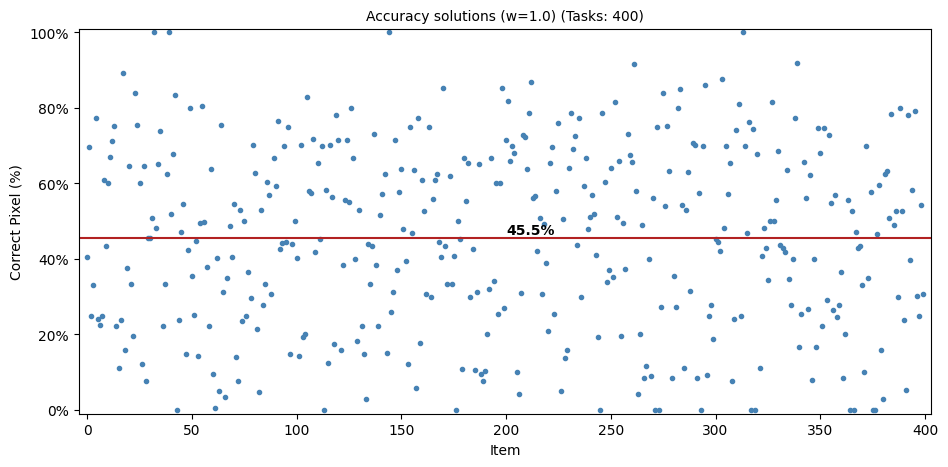

Number of 100% Correct: 4
Number of 90%+ Correct: 6
Number of 80%+ Correct: 26
Number of 70%+ Correct: 77


In [46]:
def compute_accuracy(original, decoded):
        correct = (original == decoded)
        accuracy = correct.mean().item()
        is_perfect = accuracy == 1.0
        return accuracy, is_perfect


for i in range(0, 6):     
    solved_puzzles = []

    accuracies = []
    for puzzle_id, task in data.items():
        train_pairs = process_train_pairs(pipeline, task['train'])
        test_input, test_output = task['test'][0]
        test_input = pipeline.preprocess_and_compress(test_input)    

        pred = infer_arc_transformation(pipeline, train_pairs, test_input, test_output, train_weight=(i/5))

        acc, perfect = compute_accuracy(pred, test_output)
        accuracies.append(acc)

        if perfect:
            solved_puzzles.append(puzzle_id)
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            draw_grid(axes[0], pred, f"Puzzle {puzzle_id} Predicted output")
            draw_grid(axes[1], test_output, f"Puzzle {puzzle_id} Original output")

    mean = np.mean(accuracies)
    ig, ax = plt.subplots(figsize=(11,5))
    plt.plot(accuracies, color='steelblue', marker='.', linewidth=0)
    plt.axhline(mean, xmax = len(accuracies), color='firebrick')
    plt.title(f'Accuracy solutions (w={i/5}) (Tasks: {len(accuracies)})', size='medium')
    plt.xlabel('Item')
    plt.ylabel('Correct Pixel (%)')
    plt.text(len(accuracies)/2, mean+0.01, f'{(mean*100).round(2)}%', size='medium', weight='bold')
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=max([1])))
    plt.ylim(-0.01, 1.01)
    plt.margins(x=0.01)
    plt.show()
    print(f'Number of 100% Correct: {accuracies.count(1)}')
    print(f'Number of 90%+ Correct: {sum(i >= 0.9 for i in accuracies)}')
    print(f'Number of 80%+ Correct: {sum(i >= 0.8 for i in accuracies)}')
    print(f'Number of 70%+ Correct: {sum(i >= 0.7 for i in accuracies)}')

